<a href="https://colab.research.google.com/github/gregor-posadas/Gregor-Projects/blob/main/Globally_Shared_Parameter_Based_Node_Diagram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Globally Shared Parameters**

Upload data files for the WWTP unit processes in sequence.
Enter the full path to the next process file (e.g., Influent): /content/Influent Parameters.csv
What is the name of this process? (e.g., Influent): Influent
Do you want to add another process file? (yes/no): yes
Enter the full path to the next process file (e.g., Influent): /content/Oxidation Ditch Effluent Parameters.xlsx
What is the name of this process? (e.g., Influent): Oxidation Ditch Effluent
Do you want to add another process file? (yes/no): yes
Enter the full path to the next process file (e.g., Influent): /content/Plant Effluent Parameters.xlsx
What is the name of this process? (e.g., Influent): Plant Effluent
Do you want to add another process file? (yes/no): no
Reading file: /content/Influent Parameters.csv
Applying Z-Score Method to filter outliers...
Finished processing file: /content/Influent Parameters.csv
Reading file: /content/Oxidation Ditch Effluent Parameters.xlsx
Applying Z-Score Method to filter outliers..

Bootstrapping correlation matrices...
Bootstrapping iteration 0/500...
Bootstrapping iteration 100/500...
Bootstrapping iteration 200/500...
Bootstrapping iteration 300/500...
Bootstrapping iteration 400/500...
Bootstrapping iteration 0/500...
Bootstrapping iteration 100/500...
Bootstrapping iteration 200/500...
Bootstrapping iteration 300/500...
Bootstrapping iteration 400/500...
Bootstrapping iteration 0/500...
Bootstrapping iteration 100/500...
Bootstrapping iteration 200/500...
Bootstrapping iteration 300/500...
Bootstrapping iteration 400/500...
Calculating and correcting p-values...
Calculating p-values for correlation matrix...
Correcting p-values using Benjamini-Hochberg method...
Generating heatmap...


Globally shared parameters across all node pairs: {'temperature', 'ph'}
Generating Globally Shared Network Diagram...
Processing connection: Influent → Oxidation_Ditch_Effluent
Checking parameter: temperature (temperature_Influent ↔ temperature_Oxidation_Ditch_Effluent)
Adding edge for temperature_Influent ↔ temperature_Oxidation_Ditch_Effluent (r=0.8841036383242186)
Checking parameter: ph (ph_Influent ↔ ph_Oxidation_Ditch_Effluent)
Adding edge for ph_Influent ↔ ph_Oxidation_Ditch_Effluent (r=-0.4038876336281089)
Processing connection: Oxidation_Ditch_Effluent → Plant_Effluent
Checking parameter: temperature (temperature_Oxidation_Ditch_Effluent ↔ temperature_Plant_Effluent)
Adding edge for temperature_Oxidation_Ditch_Effluent ↔ temperature_Plant_Effluent (r=0.9551421881492411)
Checking parameter: ph (ph_Oxidation_Ditch_Effluent ↔ ph_Plant_Effluent)
Adding edge for ph_Oxidation_Ditch_Effluent ↔ ph_Plant_Effluent (r=0.7781819004805852)


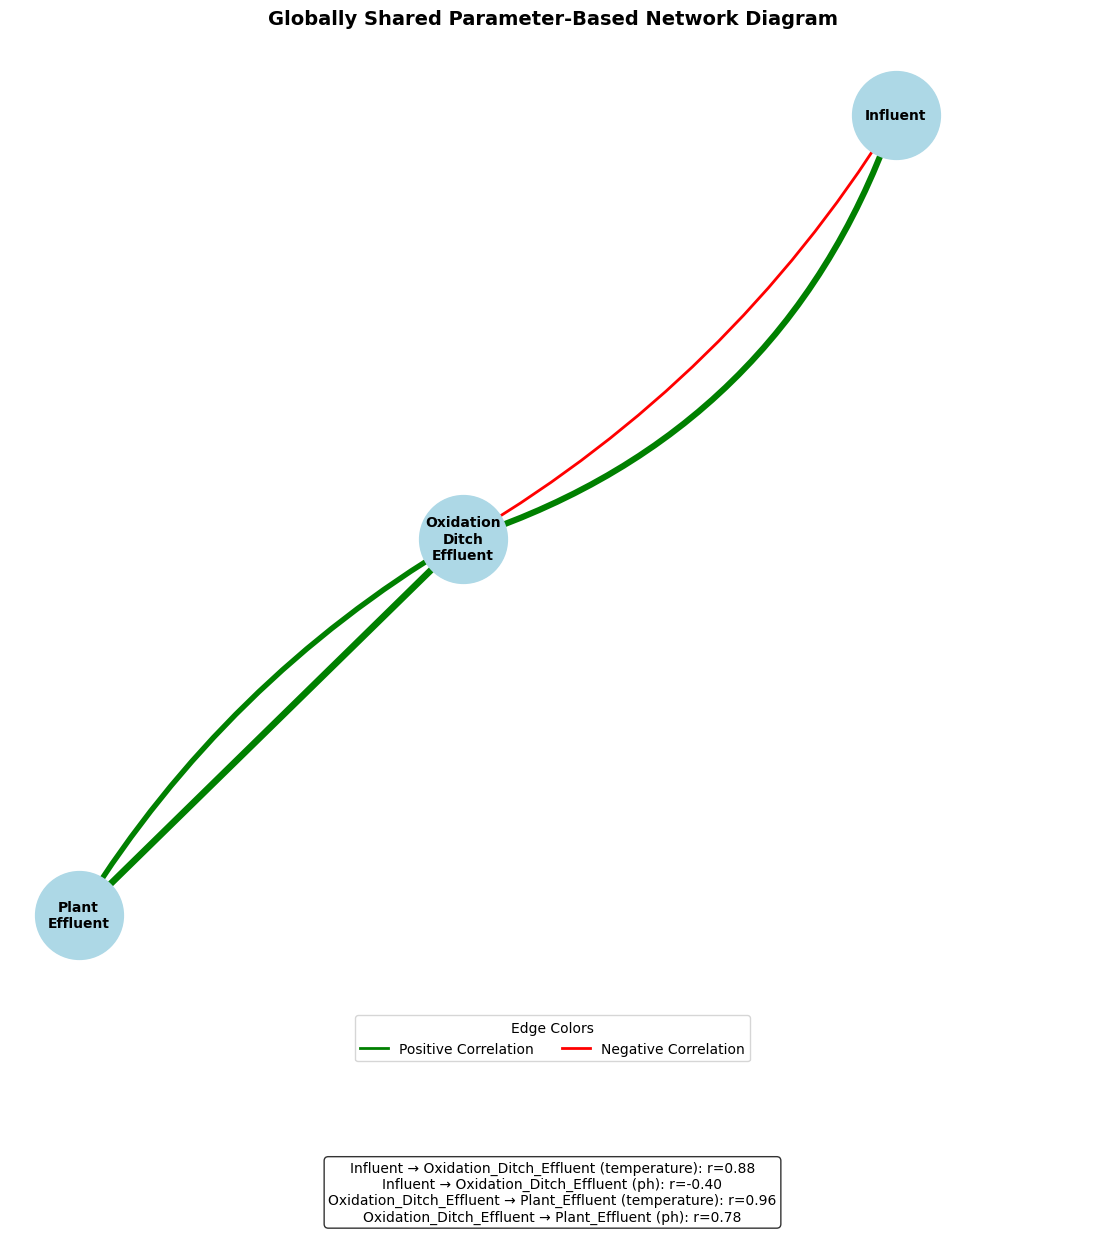

Generating Locally Shared Network Diagram...
Processing connection: Influent → Oxidation_Ditch_Effluent
Checking parameter: phosphorus (phosphorus_Influent ↔ phosphorus_Oxidation_Ditch_Effluent)
Adding edge for phosphorus_Influent ↔ phosphorus_Oxidation_Ditch_Effluent (r=0.39314801672799277)
Checking parameter: ammonia (ammonia_Influent ↔ ammonia_Oxidation_Ditch_Effluent)
Adding edge for ammonia_Influent ↔ ammonia_Oxidation_Ditch_Effluent (r=0.4508943816448703)
Checking parameter: temperature (temperature_Influent ↔ temperature_Oxidation_Ditch_Effluent)
Adding edge for temperature_Influent ↔ temperature_Oxidation_Ditch_Effluent (r=0.8841036383242186)
Checking parameter: ph (ph_Influent ↔ ph_Oxidation_Ditch_Effluent)
Adding edge for ph_Influent ↔ ph_Oxidation_Ditch_Effluent (r=-0.4038876336281089)
Processing connection: Oxidation_Ditch_Effluent → Plant_Effluent
Checking parameter: temperature (temperature_Oxidation_Ditch_Effluent ↔ temperature_Plant_Effluent)
Adding edge for temperature

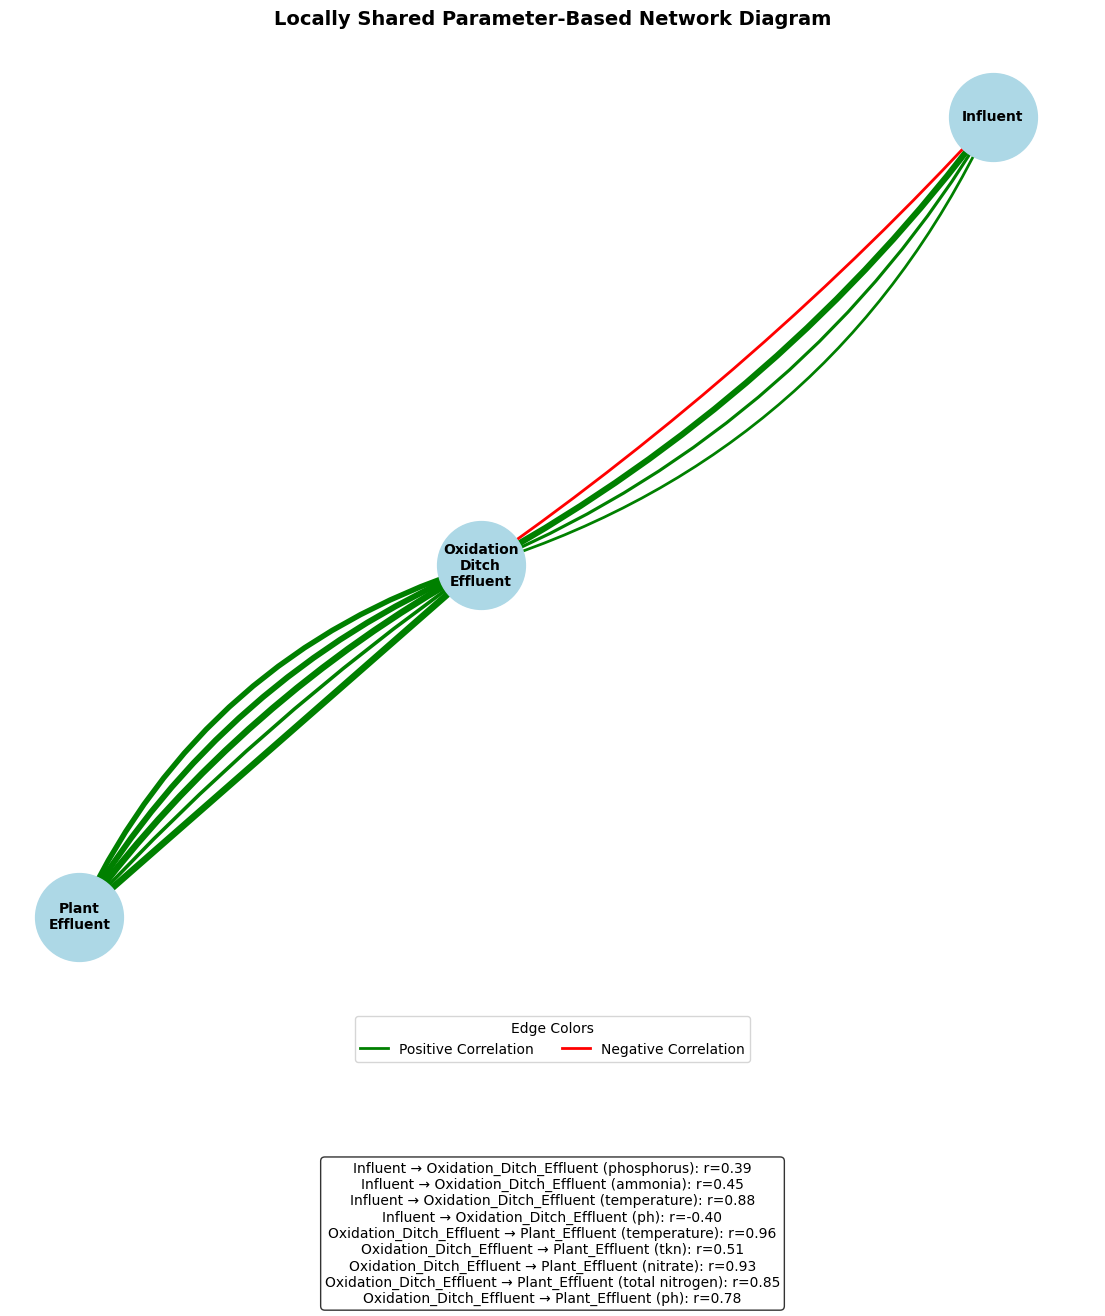

In [4]:
import pandas as pd
import numpy as np
import plotly.express as px
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.utils import resample
import itertools
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import Normalize
from matplotlib import colormaps

# Helper function to identify shared parameters
def find_common_parameters(dataframes):
    """
    Identify parameters (columns) that are common across multiple DataFrames.
    """
    if not dataframes:
        return []

    # Start with all columns from the first DataFrame
    common_columns = set(dataframes[0].columns)

    # Intersect with columns from the remaining DataFrames
    for df in dataframes[1:]:
        common_columns &= set(df.columns)

    # Exclude the 'date' column
    common_columns.discard('date')

    return list(common_columns)

# Helper function to remove outliers using Z-score
def remove_outliers_zscore(df, threshold=3):
    """
    Remove outliers from a DataFrame using the Z-score method.
    """
    print("Applying Z-Score Method to filter outliers...")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    z_scores = np.abs(stats.zscore(df[numeric_cols], nan_policy="omit"))
    mask = (z_scores < threshold).all(axis=1)
    return df[mask]

# Helper function to validate correlations
def validate_correlation_matrix(df, n_iterations=500, alpha=0.05):
    """
    Validate correlations using bootstrapping and p-value correction.
    Returns a filtered correlation matrix with only significant values.
    """
    print("Bootstrapping correlation matrices...")

    # Ensure all columns are numeric
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.dropna(axis=1, how='all')  # Drop columns that are entirely non-numeric or NaN

    pearson_corr = bootstrap_correlations(df, n_iterations=n_iterations, method='pearson')
    spearman_corr = bootstrap_correlations(df, n_iterations=n_iterations, method='spearman')
    kendall_corr = bootstrap_correlations(df, n_iterations=n_iterations, method='kendall')

    avg_corr_matrix = (pearson_corr + spearman_corr + kendall_corr) / 3

    print("Calculating and correcting p-values...")
    p_values = calculate_p_values(df, method='pearson')
    corrected_p_values = correct_p_values(p_values)

    sig_mask = (corrected_p_values < alpha).astype(int)
    filtered_corr_matrix = avg_corr_matrix.where(sig_mask > 0).fillna(0)

    return filtered_corr_matrix

# Function to generate heatmap
def generate_heatmap(df, title, labels):
    """
    Generate a heatmap and return the filtered correlation matrix.
    """
    filtered_corr_matrix = validate_correlation_matrix(df)
    parameter_order = sorted(filtered_corr_matrix.index)
    filtered_corr_matrix = filtered_corr_matrix.loc[parameter_order, parameter_order]

    np.fill_diagonal(filtered_corr_matrix.values, 1)

    print("Generating heatmap...")
    fig = px.imshow(
        filtered_corr_matrix,
        text_auto=".2f",
        color_continuous_scale="RdBu",
        zmin=-1,
        zmax=1,
        labels={"x": labels[0], "y": labels[1], "color": "Correlation Coefficient"},
        title=title,
    )

    fig.update_layout(
        title=dict(font=dict(size=20), x=0.5),
        xaxis=dict(tickangle=45, title=None, tickfont=dict(size=12)),
        yaxis=dict(title=None, tickfont=dict(size=12)),
        autosize=False,
        width=1200,
        height=1000,
        margin=dict(l=100, r=100, t=100, b=100),
    )

    fig.show()
    return filtered_corr_matrix

# Function to generate network diagram
def generate_network_diagram(labels, correlation_matrices, parameters, globally_shared=True):
    """
    Generate a parameter-based network diagram.
    If globally_shared is True, only globally shared parameters are included.
    Otherwise, locally shared parameters are used.
    """
    G = nx.MultiGraph()
    diagram_type = "Globally Shared" if globally_shared else "Locally Shared"

    print(f"Generating {diagram_type} Network Diagram...")

    for i in range(len(labels) - 1):
        print(f"Processing connection: {labels[i]} → {labels[i + 1]}")

        # Retrieve the filtered correlation matrix for this pair
        filtered_corr_matrix = correlation_matrices[i]

        # Track added edges to avoid duplicates
        added_edges = set()

        for parameter in parameters[i] if not globally_shared else parameters:
            infl_param = f"{parameter}_{labels[i]}"
            ode_param = f"{parameter}_{labels[i + 1]}"
            print(f"Checking parameter: {parameter} ({infl_param} ↔ {ode_param})")

            if infl_param in filtered_corr_matrix.index and ode_param in filtered_corr_matrix.columns:
                corr_value = filtered_corr_matrix.loc[infl_param, ode_param]

                # Skip if correlation is zero or edge already added
                edge_key = (labels[i], labels[i + 1], parameter)
                if corr_value == 0 or edge_key in added_edges:
                    continue

                # Add edge
                print(f"Adding edge for {infl_param} ↔ {ode_param} (r={corr_value})")
                G.add_edge(
                    labels[i],
                    labels[i + 1],
                    parameter=parameter,
                    correlation=corr_value,
                    weight=abs(corr_value),
                )
                added_edges.add(edge_key)

    # Adjust layout
    pos = nx.spring_layout(G, seed=42, k=0.6)

    plt.figure(figsize=(14, 12))

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=4000, node_color="lightblue")
    formatted_labels = {label: label.replace("_", "\n") for label in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=formatted_labels, font_size=10, font_weight="bold")

    for (u, v, d), idx in zip(G.edges(data=True), range(len(G.edges()))):
        curvature = 0.5 * (idx - len(G.edges()) // 2) / len(G.edges())
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=[(u, v)],
            connectionstyle=f"arc3,rad={curvature}",
            edge_color="green" if d["correlation"] > 0 else "red",
            width=d["weight"] * 5,
        )

    # Add a legend
    plt.legend(
        handles=[
            plt.Line2D([0], [0], color="green", lw=2, label="Positive Correlation"),
            plt.Line2D([0], [0], color="red", lw=2, label="Negative Correlation"),
        ],
        loc="lower center",
        bbox_to_anchor=(0.5, -0.1),
        ncol=2,
        title="Edge Colors",
    )

    # Add a text box summarizing parameter details
    edge_details = "\n".join(
        [f"{u} → {v} ({d['parameter']}): r={d['correlation']:.2f}" for u, v, d in G.edges(data=True)]
    )
    ax = plt.gca()
    ax.text(
        0.5, -0.2, edge_details,
        fontsize=10, ha="center", va="top",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3", alpha=0.8),
        transform=ax.transAxes,
    )

    plt.title(f"{diagram_type} Parameter-Based Network Diagram", fontsize=14, pad=20, weight="bold")
    plt.axis("off")
    plt.show()

# Main Function
if __name__ == "__main__":
    print("Upload data files for the WWTP unit processes in sequence.")
    process_files, process_labels = upload_files_sequentially()

    if len(process_files) < 2:
        print("Error: You need at least 2 files to generate diagrams.")
        exit()

    # Read data
    dataframes = [read_file(file) for file in process_files]

    # Common parameters
    common_params = find_common_parameters(dataframes)
    if not common_params:
        print("Error: No common parameters found.")
        exit()

    # Generate heatmaps and store correlation matrices
    correlation_matrices = []
    parameters_per_edge = []
    for i in range(len(dataframes) - 1):
        df1 = dataframes[i][['date'] + common_params]
        df2 = dataframes[i + 1][['date'] + common_params]
        merged_df = pd.merge(df1, df2, on="date", suffixes=(f"_{process_labels[i]}", f"_{process_labels[i + 1]}"))
        merged_df = merged_df.drop(columns=["date"], errors="ignore")
        filtered_corr_matrix = generate_heatmap(
            merged_df,
            f"Correlation Coefficient Heatmap: {process_labels[i]} vs {process_labels[i + 1]}",
            (process_labels[i], process_labels[i + 1]),
        )
        correlation_matrices.append(filtered_corr_matrix)

        # Identify parameters contributing to the correlation
        shared_params = []
        for param in common_params:
            infl_param = f"{param}_{process_labels[i]}"
            ode_param = f"{param}_{process_labels[i + 1]}"
            if infl_param in filtered_corr_matrix.index and ode_param in filtered_corr_matrix.columns:
                if filtered_corr_matrix.loc[infl_param, ode_param] != 0:
                    shared_params.append(param)
        parameters_per_edge.append(shared_params)

    # Identify globally shared parameters
    globally_shared_parameters = set(parameters_per_edge[0])
    for params in parameters_per_edge[1:]:
        globally_shared_parameters &= set(params)

    print(f"Globally shared parameters across all node pairs: {globally_shared_parameters}")
    if not globally_shared_parameters:
        print("Error: No globally shared parameters found.")
        exit()

    # Generate network diagrams
    generate_network_diagram(process_labels, correlation_matrices, globally_shared_parameters, globally_shared=True)
    generate_network_diagram(process_labels, correlation_matrices, parameters_per_edge, globally_shared=False)


# **Data Processing Methodology Flowchart**

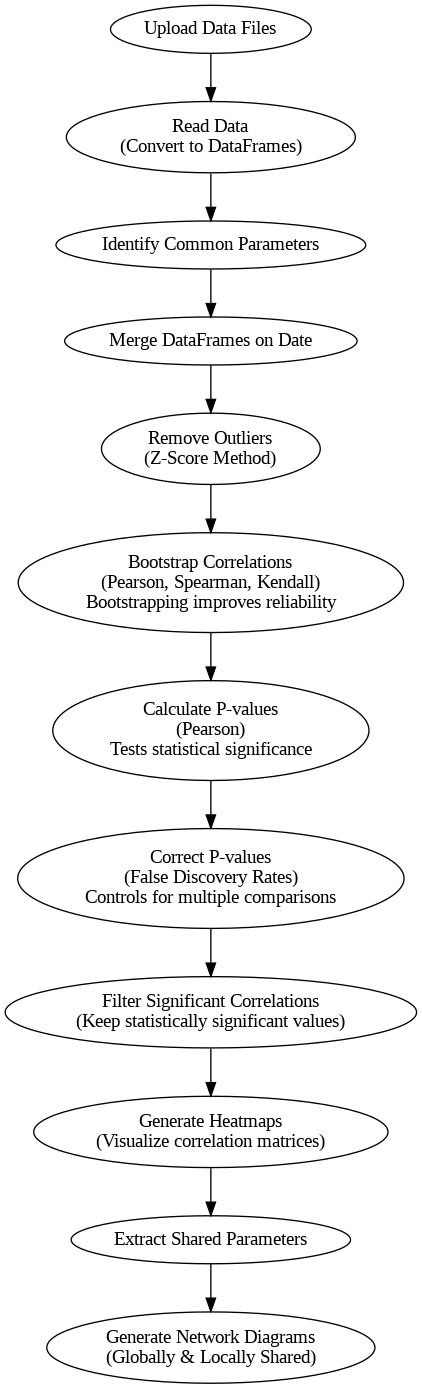

In [11]:
from graphviz import Digraph
from IPython.display import Image, display

def create_flowchart():
    dot = Digraph(comment="Network Diagram Production Flowchart")

    # Nodes with subtitles in labels
    dot.node("A", "Upload Data Files")
    dot.node("B", "Read Data\n(Convert to DataFrames)")
    dot.node("C", "Identify Common Parameters")
    dot.node("D", "Merge DataFrames on Date")
    dot.node("E", "Remove Outliers\n(Z-Score Method)")
    dot.node("F", "Bootstrap Correlations\n(Pearson, Spearman, Kendall)\nBootstrapping improves reliability")
    dot.node("G", "Calculate P-values\n(Pearson)\nTests statistical significance")
    dot.node("H", "Correct P-values\n(False Discovery Rates)\nControls for multiple comparisons")
    dot.node("I", "Filter Significant Correlations\n(Keep statistically significant values)")
    dot.node("J", "Generate Heatmaps\n(Visualize correlation matrices)")
    dot.node("K", "Extract Shared Parameters")
    dot.node("L", "Generate Network Diagrams\n(Globally & Locally Shared)")

    # Edges
    dot.edge("A", "B")
    dot.edge("B", "C")
    dot.edge("C", "D")
    dot.edge("D", "E")
    dot.edge("E", "F")
    dot.edge("F", "G")
    dot.edge("G", "H")
    dot.edge("H", "I")
    dot.edge("I", "J")
    dot.edge("J", "K")
    dot.edge("K", "L")

    # Save to a temporary file and display
    filepath = "network_diagram_flowchart.png"
    dot.render(filepath, format="png", cleanup=True)
    display(Image(filepath + ".png"))

create_flowchart()
